# `synthesizAR` Test Drive
The `synthesizAR` package is tentatively at version 0.1. Let's test it from end to end and see how it does.

In [1]:
import subprocess
import os
import logging
logging.basicConfig(level=logging.INFO)
import urllib
import functools
import glob
import itertools

import pandas
import h5py
from IPython.display import HTML
import astropy.units as u
import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn.apionly as sns
from sunpy.net import vso
import sunpy.map
import astropy.units as u
from ChiantiPy.tools import util as ch_tools_util

import synthesizAR
from synthesizAR.atomic import EquilibriumEmissionModel,ChIon
from synthesizAR.model_ext import EbtelInterface,PowerLawScaledWaitingTimes
from synthesizAR.instruments import InstrumentHinodeEIS,InstrumentSDOAIA

%matplotlib inline

/opt/anaconda3/envs/synthesizar/lib/python3.5/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


 using cli
 using CLI for selections
 reading chiantirc file


In [2]:
ar_root = '/data/datadrive2/ar_viz/synthesizar_v01demo/'

## Create Magnetic Skeleton
Let's choose a new active region to look at. [Viall and Klimchuk (2012)](https://ui.adsabs.harvard.edu/#abs/2012ApJ...753...35V/abstract) perform a time-lag analysis using SDO/AIA observations of NOAA AR 11082.

In [ ]:
client = vso.VSOClient()
result_hmi = client.query(
    vso.attrs.Time(('2010-Jun-19 03:05:00'), ('2010-Jun-19 03:06:00')),
    vso.attrs.Instrument('HMI'),
    vso.attrs.Physobs('LOS_magnetic_field'),   # Physical observables
)

In [ ]:
data_hmi = client.get(result_hmi,methods=('URL-FILE_Rice','URL-FILE')).wait()

In [ ]:
crop = (u.Quantity([-400,-140]*u.arcsec),u.Quantity([320,540]*u.arcsec))
resample = u.Quantity([100,100]*u.pixel)
field = synthesizAR.Skeleton(data_hmi[0],crop=crop,resample=resample)
zshape=50
zrange=u.Quantity([0.,150.]*u.arcsec)
field.extrapolate_field(zshape,zrange)

In [ ]:
field.extract_streamlines(500,loop_length_range=[1e+9,1e+11]*u.cm)

In [ ]:
field.peek(alpha=0.5)

## Run Loop Simulations
Now run EBTEL simulations for each of the loops in our active region. We'll use a nanoflare storm lasting $1\times10^4$ s with an average of 3000 s between each heating event on each loop.

In [ ]:
field.make_loops()

What is the distribution of loop lengths in this active region as determined by the field extrapolation?

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.hist(np.array([loop.full_length.to(u.Mm).value for loop in field.loops]),
        bins=10,
        alpha=0.5,
        #log=True,
        color=sns.color_palette('deep')[2]
       )
ax.set_ylabel(r'Number of Loops')
ax.set_xlabel(r'$L$ ($\mathrm{{ {} }}$)'.format(field.loops[0].full_length.to(u.Mm).unit.name))
#ax.set_xscale('log')
ax.set_xlim([0,500])
plt.show()

In [ ]:
heating_options = {
    'duration':200.0,
    'duration_rise':100.0,
    'duration_decay':100.0,
    'average_waiting_time':2000.0,
    'stress_level':0.3,
    'alpha':-2.5,
    'delta_power_law_bounds':100,
    'waiting_time_scaling':1.0,
}
heating_model = PowerLawScaledWaitingTimes(heating_options)

In [ ]:
ih = synthesizAR.util.InputHandler(os.path.join(os.environ['RESEARCH_DIR'],'ebtelPlusPlus/config/ebtel.example.cfg.xml'))
base_config = ih.lookup_vars()
base_config['c1_cond0'] = 6.0
base_config['use_adaptive_solver'] = True
base_config['tau'] = 1.0
base_config['adaptive_solver_error'] = 1e-12
base_config['adaptive_solver_safety'] = 0.01
base_config['total_time'] = 10000.0
ebtel_plug = EbtelInterface(base_config,heating_model)
field.configure_loop_simulations(ebtel_plug,
                                 parent_config_dir=os.path.join(ar_root,'hydro_config'),
                                 parent_results_dir=os.path.join(ar_root,'hydro_results'))

In [ ]:
for loop in field.loops:
    subprocess.call([os.path.join(os.environ['RESEARCH_DIR'],'ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

In [ ]:
field.load_loop_simulations(ebtel_plug,savefile=os.path.join(ar_root,'loop_parameters.h5'))

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(10,8),sharex=True)
for loop in field.loops:
    ax[0].plot(loop.time,loop.temperature[:,0],color=sns.color_palette('deep')[0],alpha=0.05)
    ax[1].plot(loop.time,loop.density[:,0],color=sns.color_palette('deep')[2],alpha=0.05)
ax[0].set_ylabel(r'$T$ ({0})'.format(loop.temperature.unit.to_string()))
ax[1].set_ylabel(r'$n$ ({0:latex})'.format(loop.density.unit))
ax[1].set_xlabel(r'$t$ ({})'.format(loop.time.unit))
#ax[1].set_xlim([3600,3800])

## Simulate Emission
First, if we want to model emission of individual spectral lines, we need to choose which lines of which ions we want to consider. We'll use the line list of [Warren et al. (2012)](http://iopscience.iop.org/article/10.1088/0004-637X/759/2/141/meta) who performed a systematic survey of 16 different active regions, including NOAA 1082. They provide a machine-readable table of their line list so we'll download that and format the list appropriately.

In [2]:
new_linelist = [list(filter(None,line.decode('utf-8').strip('\n').split(' '))) \
                for line in urllib.request.urlopen('http://iopscience.iop.org/0004-637X/759/2/141/suppdata/apj446760t2_mrt.txt').readlines()[19:]]

In [4]:
ions = []
for line in new_linelist:
    if int(line[0]) == 1 and line[1] == 'EIS':
        el = line[2]
        ion = line[3]
        wvl = float(line[4])
        el_ion = ch_tools_util.spectroscopic2name(el,ion)
        try:
            index = next(index for (index, d) in enumerate(ions) if d["name"] == el_ion)
            ions[index]['wavelengths'] = (list(ions[index]['wavelengths'].value) + [wvl])*u.angstrom
        except StopIteration:
            ions.append({'name':el_ion,'wavelengths':[wvl]*u.angstrom})

In [5]:
ions

[{'name': 'si_7', 'wavelengths': <Quantity [ 275.368] Angstrom>},
 {'name': 'fe_9', 'wavelengths': <Quantity [ 188.497] Angstrom>},
 {'name': 'fe_10', 'wavelengths': <Quantity [ 184.536] Angstrom>},
 {'name': 'fe_11', 'wavelengths': <Quantity [ 188.216] Angstrom>},
 {'name': 'fe_12', 'wavelengths': <Quantity [ 192.394, 195.119] Angstrom>},
 {'name': 'fe_13', 'wavelengths': <Quantity [ 202.044, 203.826] Angstrom>},
 {'name': 'fe_15', 'wavelengths': <Quantity [ 284.16] Angstrom>},
 {'name': 's_13', 'wavelengths': <Quantity [ 256.686] Angstrom>},
 {'name': 'fe_16', 'wavelengths': <Quantity [ 262.984] Angstrom>},
 {'name': 'ca_17', 'wavelengths': <Quantity [ 192.858] Angstrom>}]

Make some minor updates to our line list

In [ ]:
ions.pop(1)

In [ ]:
ions[0]['wavelengths'] = [275.3612]*u.angstrom
ions[1]['wavelengths'] = [184.537]*u.angstrom
ions[5]['wavelengths'] = [284.163]*u.angstrom
ions[6]['wavelengths'] = [256.6852]*u.angstrom
ions[7]['wavelengths'] = [262.976]*u.angstrom
ions[8]['wavelengths'] = [192.8532]*u.angstrom

In [ ]:
ions

Now, feed these to our emission model.

In [ ]:
emiss_model = EquilibriumEmissionModel(ions,temperature=np.logspace(5,8,100)*u.K,
                                       density=np.logspace(8,11,100)/u.cm**3,
                                       chianti_db_filename=os.path.join(ar_root,'chianti_db.h5'),
                                       energy_unit='photon')

Now build up the ionization equilibrium and emissivity arrays. This will probably take a while.

In [ ]:
emiss_model.calculate_fractional_ionization()

In [ ]:
for ion in emiss_model.ions:
    plt.plot(emiss_model.temperature_mesh[:,0],ion['fractional_ionization'][:,0],label=ion['ion'].meta['spectroscopic_name'])
plt.xscale('log')
plt.xlabel(r'$T$ ({})'.format(emiss_model.temperature_mesh.unit))
plt.legend()

In [ ]:
emiss_model.calculate_emissivity()

Save the emission model so we can use it later without having to recalculate the emissivity.

In [ ]:
emiss_model.save(os.path.join(ar_root,'checkpoint_emiss_model'))

Finally, pass the emissivity model to the field so that the emissivity can be calculated for each loop.

In [ ]:
field.logger.setLevel(logging.INFO)
field.calculate_emission(emiss_model,savefile=os.path.join(ar_root,'loop_emiss.h5'))

Save the field again.

In [ ]:
field.save(savedir=os.path.join(ar_root,'checkpoint'))

Here, reload the field and emission model as needed.

In [3]:
field = synthesizAR.Skeleton.restore(os.path.join(ar_root,'checkpoint'))

yt : [INFO     ] 2017-01-05 15:06:51,692 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-01-05 15:06:51,694 Parameters: domain_dimensions         = [96 96 46]
yt : [INFO     ] 2017-01-05 15:06:51,695 Parameters: domain_left_edge          = [ -2.89511786e+10   2.37893407e+10   4.40182588e+08]
yt : [INFO     ] 2017-01-05 15:06:51,696 Parameters: domain_right_edge         = [ -1.06601257e+10   3.93100982e+10   1.05643821e+10]
yt : [INFO     ] 2017-01-05 15:06:51,697 Parameters: cosmological_simulation   = 0.0


In [4]:
emiss_model = EquilibriumEmissionModel.restore(os.path.join(ar_root,'checkpoint_emiss_model'))

INFO:EquilibriumEmissionModel:Using CHIANTI HDF5 database in /data/datadrive2/ar_viz/synthesizar_v01demo/chianti_db.h5
INFO:EquilibriumEmissionModel:Creating ion si_7
INFO:EquilibriumEmissionModel:Creating ion fe_10
INFO:EquilibriumEmissionModel:Creating ion fe_11
INFO:EquilibriumEmissionModel:Creating ion fe_12
INFO:EquilibriumEmissionModel:Creating ion fe_13
INFO:EquilibriumEmissionModel:Creating ion fe_15
INFO:EquilibriumEmissionModel:Creating ion s_13
INFO:EquilibriumEmissionModel:Creating ion fe_16
INFO:EquilibriumEmissionModel:Creating ion ca_17
INFO:EquilibriumEmissionModel:Restoring emission model from /data/datadrive2/ar_viz/synthesizar_v01demo/checkpoint_emiss_model


## Detect
We'll observe this active region using the EIS instrument on _Hinode_ and the AIA instrument on SDO. First setup the instruments,

In [5]:
eis = InstrumentHinodeEIS('/home/wtb2/Documents/Forward_Model/instruments/Hinode_EIS/',[0,9900]*u.s)

In [6]:
aia = InstrumentSDOAIA([0,9900]*u.s,response_function_file='aia_tresponse_raw.dat')

Leave out all of the EIS channels we don't need. Probably need a better way of dealing with this in the future.

In [7]:
new_channels = []
for channel in eis.channels:
    for wvl in emiss_model.wavelengths:
        if channel['response']['x'][0] <= wvl <= channel['response']['x'][-1]:
            new_channels.append(channel)
            break
eis.channels = new_channels

Create the observer, build the detector files, and calculate the counts. Only looking at AIA right now. EIS detect function needs some speedup...too many unnecessary interpolations.

In [8]:
observer = synthesizAR.Observer(field,[aia,eis],ds=field._convert_angle_to_length(0.3*u.arcsec))

/opt/anaconda3/envs/synthesizar/lib/python3.5/site-packages/scipy/interpolate/fitpack.py:300: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/opt/anaconda3/envs/synthesizar/lib/python3.5/site-packages/scipy/interpolate/fitpack.py:300: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


In [9]:
observer.build_detector_files(ar_root)

INFO:Observer:Creating instrument file /data/datadrive2/ar_viz/synthesizar_v01demo/SDO_AIA_counts.h5
INFO:Observer:Creating instrument file /data/datadrive2/ar_viz/synthesizar_v01demo/Hinode_EIS_counts.h5


In [10]:
observer.logger.setLevel(logging.INFO)
observer.calculate_detector_counts()

INFO:Observer:Calculating counts for SDO_AIA
INFO:Observer:Calculating counts for channel 94
INFO:Observer:Calculating counts for channel 131
INFO:Observer:Calculating counts for channel 171
INFO:Observer:Calculating counts for channel 193
INFO:Observer:Calculating counts for channel 211
INFO:Observer:Calculating counts for channel 335
INFO:Observer:Calculating counts for Hinode_EIS
INFO:Observer:Calculating counts for channel Fe_X_184.537
INFO:Observer:Calculating counts for channel Fe_XI_188.232
INFO:Observer:Calculating counts for channel Fe_XII_192.394
INFO:Observer:Calculating counts for channel Fe_XI_192.83
INFO:Observer:Calculating counts for channel Ca_XVII_192.853
INFO:Observer:Calculating counts for channel Fe_XII_195.119
INFO:Observer:Calculating counts for channel Fe_XIII_202.044
INFO:Observer:Calculating counts for channel Fe_XIII_203.828
INFO:Observer:Calculating counts for channel S_XIII_256.685
INFO:Observer:Calculating counts for channel Fe_XVI_262.976
INFO:Observer:Ca

In [11]:
observer.bin_detector_counts(ar_root,apply_psf=[True,False])

INFO:Observer:Building maps for SDO_AIA
INFO:Observer:Building maps for channel 94
INFO:Observer:Building maps for channel 131
INFO:Observer:Building maps for channel 171
INFO:Observer:Building maps for channel 193
INFO:Observer:Building maps for channel 211
INFO:Observer:Building maps for channel 335
INFO:Observer:Building maps for Hinode_EIS
INFO:Observer:Building maps for channel Fe_X_184.537
INFO:Observer:Building maps for channel Fe_XI_188.232
INFO:Observer:Building maps for channel Fe_XII_192.394
INFO:Observer:Building maps for channel Fe_XI_192.83
INFO:Observer:Building maps for channel Ca_XVII_192.853
INFO:Observer:Building maps for channel Fe_XII_195.119
INFO:Observer:Building maps for channel Fe_XIII_202.044
INFO:Observer:Building maps for channel Fe_XIII_203.828
INFO:Observer:Building maps for channel S_XIII_256.685
INFO:Observer:Building maps for channel Fe_XVI_262.976
INFO:Observer:Building maps for channel Si_VII_275.354
INFO:Observer:Building maps for channel Fe_XV_284.1

(0, 75)

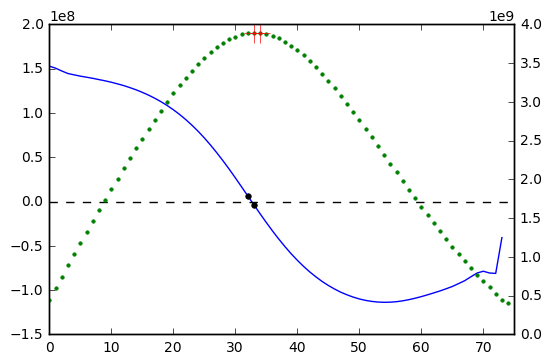

In [62]:
fig = plt.figure()
ax = fig.gca()
delta = np.diff(field.loops[0].coordinates[:,2]).value
i_apex = np.where(delta>0)[0][-1]
ax.plot(delta)
ax.plot([i_apex,i_apex+1],delta[[i_apex,i_apex+1]],marker='.',markersize=8,linestyle='',color='k')
axtwin = ax.twinx()
axtwin.plot(field.loops[0].coordinates[:,2].value,color='g',marker='.',linestyle='',markersize=5)
axtwin.plot([i_apex+1,i_apex+2],field.loops[0].coordinates[:,2].value[[i_apex+1,i_apex+2]],color='r',marker='+',linestyle='',markersize=15)
ax.axhline(y=0,color='k',linestyle='--')
ax.set_xlim([0,len(field.loops[0].coordinates)])
#ax.set_xlim([20,50])

In [113]:
field.loops[0].coordinates.unit.to_string()

'cm'

In [120]:
print('B-field range = {:.2f}'.format(np.max(field.loops[0].field_strength)))
print('Footpoints = ({}),({}) {}'.format(','.join(['{:.3g}'.format(l) for l in field.loops[0].coordinates[0,:].value]),
                                         ','.join(['{:.3g}'.format(l) for l in field.loops[0].coordinates[-1,:].value]),
                                         field.loops[0].coordinates.unit))
print('{:.3f}'.format(field.loops[0].full_length.to(u.Mm)))

B-field range = 332.99 G
Footpoints = (-1.81e+10,2.96e+10,4.4e+08),(-2.26e+10,3.31e+10,4.07e+08) cm
117.916 Mm


In [85]:
print('''HMI Map:
--------

{}'''.format(field.hmi_map.__repr__()))

HMI Map:
--------

SunPy HMIMap
---------
Observatory:	 SDO
Instrument:	 HMI FRONT2
Detector:	 HMI
Measurement:	 magnetogram
Wavelength:	 6173.0 Angstrom
Obs Date:	 2010-06-19 03:05:11
dt:		 0.000000 s
Dimension:	 [ 100.  100.] pix
scale:		 [ 2.5970832   2.20373856] arcsec / pix

array([[ -8.88532297e+00,  -2.33225341e+00,  -1.15129654e+00, ...,
          6.70743833e+01,   3.64494846e+01,   4.53034456e+01],
       [ -1.28923312e-01,   1.00131157e+01,   6.50189292e+00, ...,
          1.45766691e+02,   5.39895510e+01,   3.13857756e+01],
       [ -8.80020624e+00,  -4.52689471e+00,   2.51811010e+01, ...,
          1.02405463e+02,   9.08592768e+01,   9.02500885e+00],
       ..., 
       [  5.81135439e-01,  -1.30688673e+00,  -1.91652557e+00, ...,
         -1.64887548e+01,  -3.77669367e+01,  -1.46068694e+01],
       [  1.87221297e+01,  -3.78750968e+00,  -1.23853021e+01, ...,
         -1.92598039e+01,  -3.31028071e+01,  -2.13145639e+01],
       [  3.79135342e+00,   8.11108202e+00,   3.13494290

## Visualize

We can try to do a time-lag analysis similar to work by Viall and Klimchuk. First, let's take the 171 and 211 Å channels and make them into mapcubes.

In [78]:
def plot_aia_frame(time,j,intensity_ranges,fig):
    fits_file_template = os.path.join(ar_root,'SDO_AIA/{channel}/map_t{time:06d}.fits')
    fig.suptitle(r'$t=${0} {1}'.format(time.value,time.unit),fontsize=16)
    for i,channel in enumerate(aia.channels):
        _tmp_map = sunpy.map.Map(fits_file_template.format(channel=channel['name'],time=j))
        ax = fig.add_subplot(2,3,i+1,projection=_tmp_map)
        _tmp_map.plot_settings['cmap'].set_bad('black',1.)
        _tmp_map.plot(axes=ax,norm=matplotlib.colors.LogNorm(vmin=intensity_ranges[channel['name']][0],
                      vmax=intensity_ranges[channel['name']][1]),
                      annotate=False)
        #_tmp_map.draw_rectangle((-310, 405)*u.arcsec, 80*u.arcsec, 1*u.arcsec,lw=1,color='red')
        ax.set_title(r'{0} $\mathrm{{\mathring{{A}}}}$'.format(channel['name']))
        if i>2:
            ax.set_xlabel(r'$x$ ({})'.format(_tmp_map.xrange.unit))
        if i==0 or i==3:
            ax.set_ylabel(r'$y$ ({})'.format(_tmp_map.yrange.unit))

def plot_eis_frame(time,j,intensity_ranges,fig):
    fits_file_template = os.path.join(ar_root,'Hinode_EIS/{channel}/map_t{time:06d}.fits')
    fig.suptitle(r'$t=${0} {1}'.format(time.value,time.unit),fontsize=16)
    for i,channel in enumerate(eis.channels):
        _tmp_map = sunpy.map.Map(fits_file_template.format(channel=channel['name'],time=j))
        ax = fig.add_subplot(4,3,i+1,projection=_tmp_map)
        _tmp_map.plot_settings['cmap'] = sunpy.cm.get_cmap('hinodexrt')
        _tmp_map.plot_settings['cmap'].set_bad('black',1.)
        _tmp_map.plot(axes=ax,norm=matplotlib.colors.LogNorm(vmin=intensity_ranges[channel['name']][0],
                      vmax=intensity_ranges[channel['name']][1]),
                      annotate=False)
        #_tmp_map.draw_rectangle((-310, 405)*u.arcsec, 80*u.arcsec, 1*u.arcsec,lw=1,color='red')
        ax.set_title(r'{} {} {} $\mathrm{{\mathring{{A}}}}$'.format(channel['name'].split('_')[0],
                                                                    channel['name'].split('_')[1],
                                                                    channel['name'].split('_')[2],))
        if i>8:
            ax.set_xlabel(r'$x$ ({})'.format(_tmp_map.xrange.unit))
        if i==0 or i==3 or i==6 or i==9:
            ax.set_ylabel(r'$y$ ({})'.format(_tmp_map.yrange.unit))

In [83]:
intensity_ranges = {
    '94':[10,1000],
    '131':[10,1000],
    '171':[10,1000],
    '193':[10,1000],
    '211':[10,1000],
    '335':[10,1000]
}
intensity_ranges_aia = {chan['name']:[1,1000] for chan in aia.channels}
intensity_ranges_eis = {chan['name']:[1,1000] for chan in eis.channels}

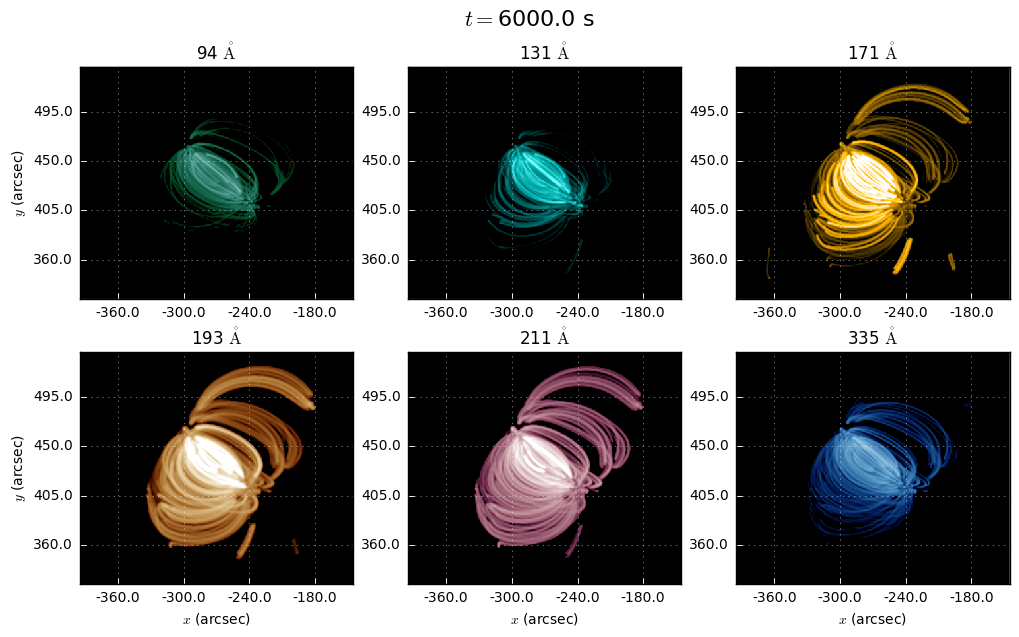

In [84]:
fig = plt.figure(figsize=(12,6.75))
time = 6000*u.s
j = np.argwhere(aia.observing_time.value==time.value)[0][0]
plot_aia_frame(time,j,intensity_ranges_aia,fig)

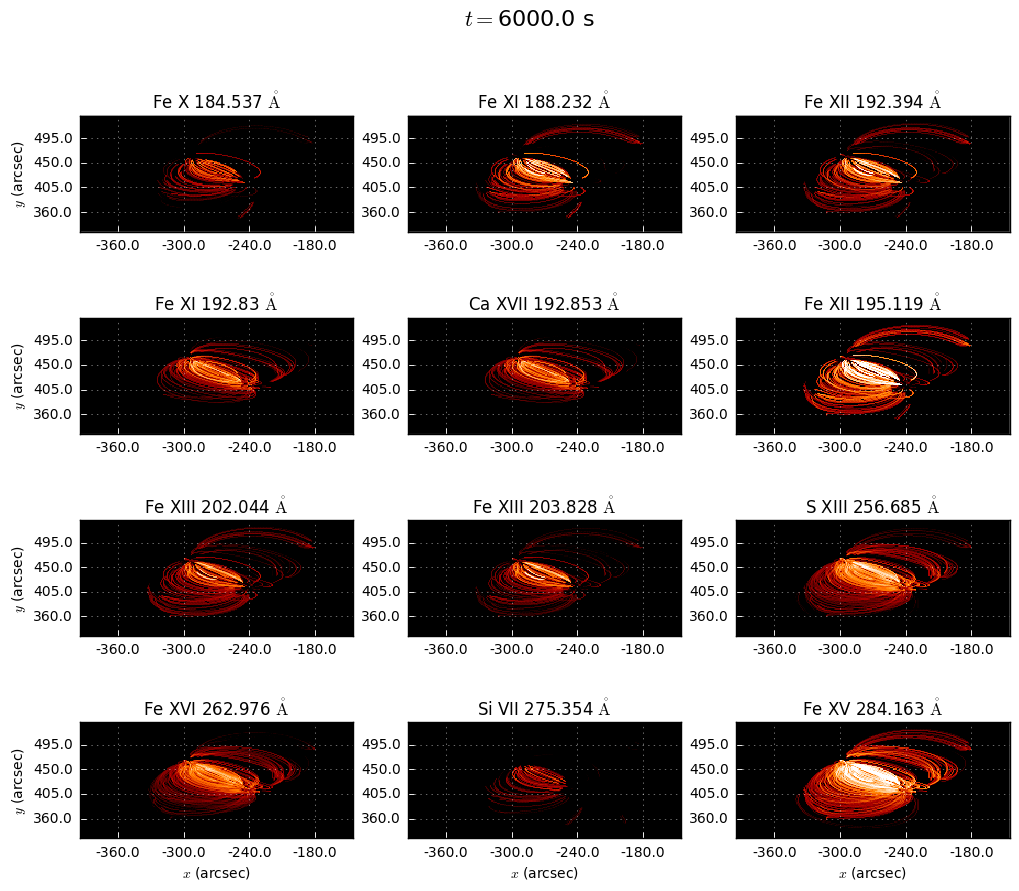

In [85]:
fig = plt.figure(figsize=(12,10))
time = 6000*u.s
j = np.argwhere(aia.observing_time.value==time.value)[0][0]
plot_eis_frame(time,j,intensity_ranges_eis,fig)

In [ ]:
fits_file_template = os.path.join(ar_root,'SDO_AIA/{channel}/map_t{time:06d}.fits')
pdf_file_template = os.path.join(ar_root,'figs','SDO_AIA','all_channels_t{time:06d}.pdf')
fig = plt.figure(figsize=(12,6.75))
for j,time in enumerate(aia.observing_time):
    plot_aia_frame(time,j,intensity_ranges,fig)
    plt.savefig(pdf_file_template.format(time=j))
    fig.clf()

We can also slice through the datacube at any particular spot to get an intensity timeseries.

In [86]:
timeseries = {}
for chan in aia.channels:
    print(chan['name'])
    tmp_file_list = glob.glob(os.path.join(ar_root,'SDO_AIA/{channel}/*.fits').format(channel=chan['name']))
    timeseries[chan['name']] = np.zeros(len(tmp_file_list))
    for i,file in enumerate(tmp_file_list):
        tmp_map = sunpy.map.Map(file)
        xcore,ycore = tmp_map.data_to_pixel(-270*u.arcsec,405*u.arcsec)
        timeseries[chan['name']][i] = tmp_map.data[int(np.ceil(ycore.value)),int(np.ceil(xcore.value))]
    timeseries[chan['name']] = timeseries[chan['name']]*u.Unit(tmp_map.meta['bunit'])

94
131
171
193
211
335


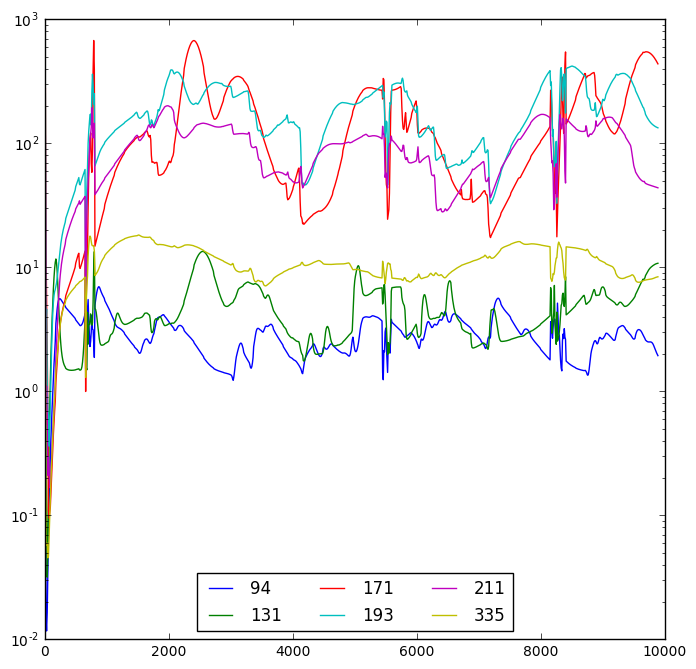

In [100]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
for channel in aia.channels:
    ax.plot(aia.observing_time,timeseries[channel['name']],label=channel['name'])
ax.legend(loc='lower center',ncol=3)
ax.set_yscale('log')
#ax.set_xlim([600,900])

Let's look quickly at the time lags between a couple of channel pairs.

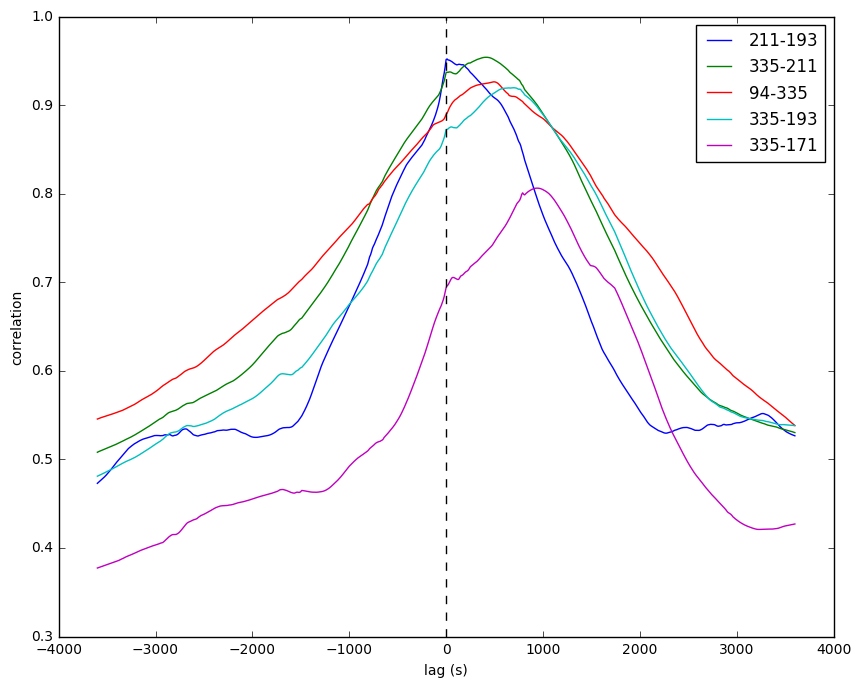

In [88]:
pairs = [(211,193),(335,211),(94,335),(335,193),(335,171)]
timeseries_time = aia.observing_time
data = []
for p in pairs:
    int2 = timeseries[str(p[0])]/np.max(timeseries[str(p[0])])
    int1 = timeseries[str(p[1])]/np.max(timeseries[str(p[1])])
    lag_indices,cor,_,_ = plt.xcorr(int1,int2,normed=True,usevlines=False,maxlags=360)
    plt.close()
    lag = np.array([-timeseries_time[-li].value if li<0 else timeseries_time[li].value for li in lag_indices])*u.s
    data.append({'lags':lag,'cor':cor})
fig = plt.figure(figsize=(10,8))
ax = fig.gca()
for p,d in zip(pairs,data):
    ax.plot(d['lags'],d['cor'],label=r'{}-{}'.format(p[0],p[1]))
#ax.set_xlim([-2500,2500])
#ax.set_title(r'$2L$ = {L:2.2f}'.format(L=test_loop.full_length.to(u.Mm),Lu=u.Mm))
ax.legend(loc='best')
ax.set_xlabel(r'lag ({})'.format(lag.unit))
ax.set_ylabel(r'correlation')
ax.axvline(x=0.0,color='k',linestyle='--')

We can also visualize a slice (as indicated in the AIA images above) through the EIS data as a function of time for every channel.

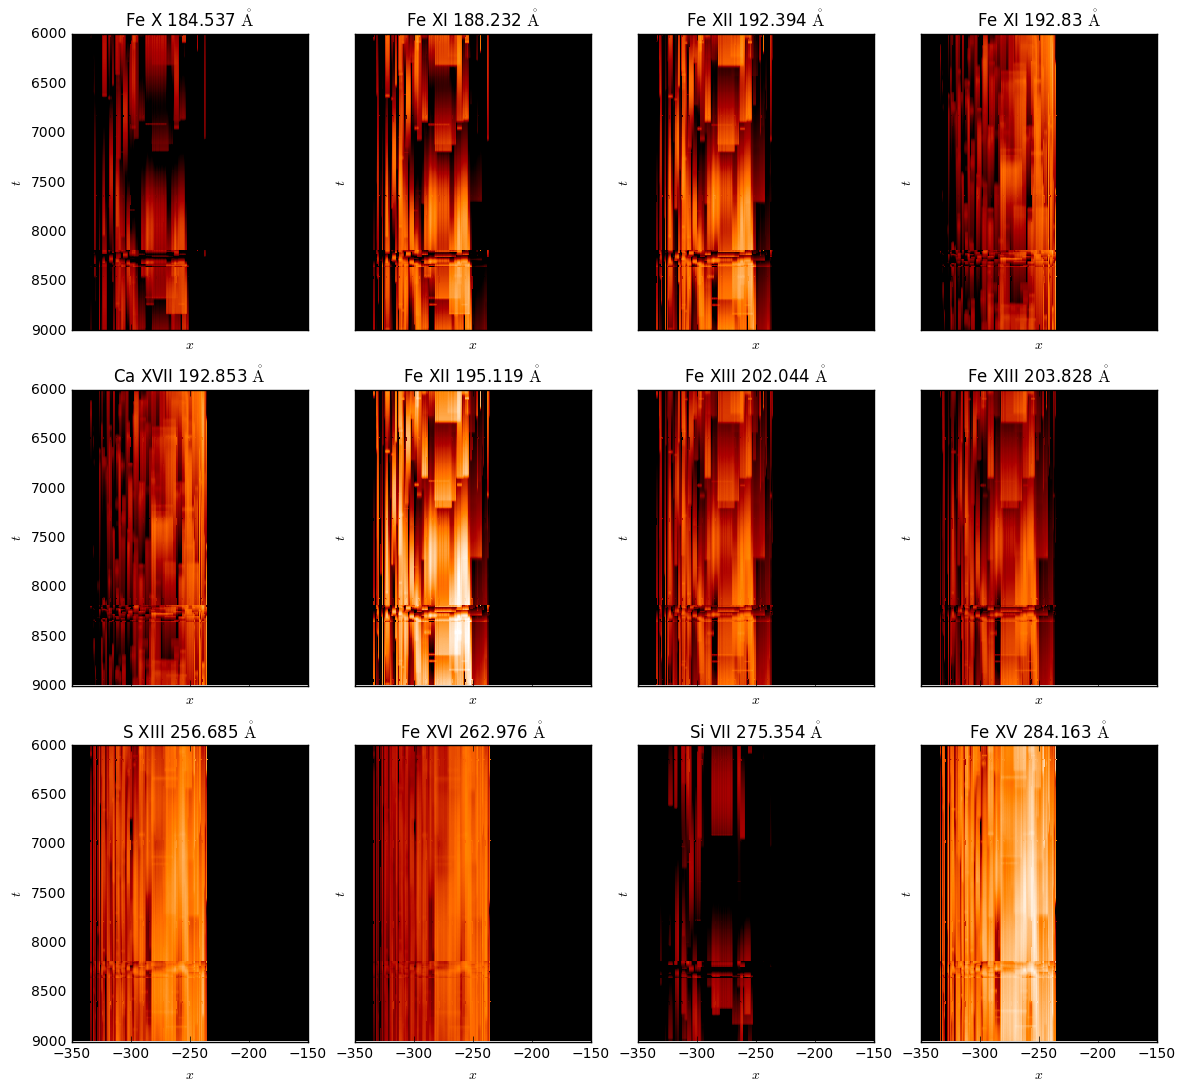

In [91]:
intensity_ranges = {chan['name']:[0.1,500] for chan in eis.channels}
fig,axes = plt.subplots(3,4,figsize=(14,13),sharex=True,sharey=True)
#fig.suptitle(r'$t=${0} ({1})'.format(time,eis.observing_time.unit),fontsize=16)
for ax,channel in zip(axes.flatten(),eis.channels):
    fits_file_template = glob.glob(os.path.join(ar_root,'Hinode_EIS/{channel}/map_t000[6-8][0-9][0-9].fits').format(channel=channel['name']))
    _tmp_map = sunpy.map.Map(fits_file_template,cube=True)
    x1,y1 = _tmp_map[0].data_to_pixel(-350*u.arcsec,405*u.arcsec)
    x2,y2 = _tmp_map[0].data_to_pixel(-150*u.arcsec,405*u.arcsec)
    xmesh,tmesh = np.meshgrid(np.arange(-350,-150+1,1),
                              eis.observing_time.value[600:900])
    cube_slice = _tmp_map.as_array()[int(np.ceil(y1.value)):int(np.ceil(y2.value))+1,
                                     int(np.ceil(x1.value)):int(np.ceil(x2.value))+1,:]
    ax.pcolormesh(xmesh,tmesh,cube_slice[0,:,:].T,cmap=sunpy.cm.get_cmap('hinodexrt'),
                norm = matplotlib.colors.LogNorm(vmin=0.1,vmax=500))
    ax.set_title(r'{0} {1} {2} $\mathrm{{\mathring{{A}}}}$'.format(channel['name'].split('_')[0],
                                                                   channel['name'].split('_')[1],
                                                                   channel['name'].split('_')[2]))
    #ax.set_xlim([-310,-230])
    ax.set_ylim([eis.observing_time[600].value,eis.observing_time[900].value])
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$t$')
    ax.invert_yaxis()

We can also go back and look at the 

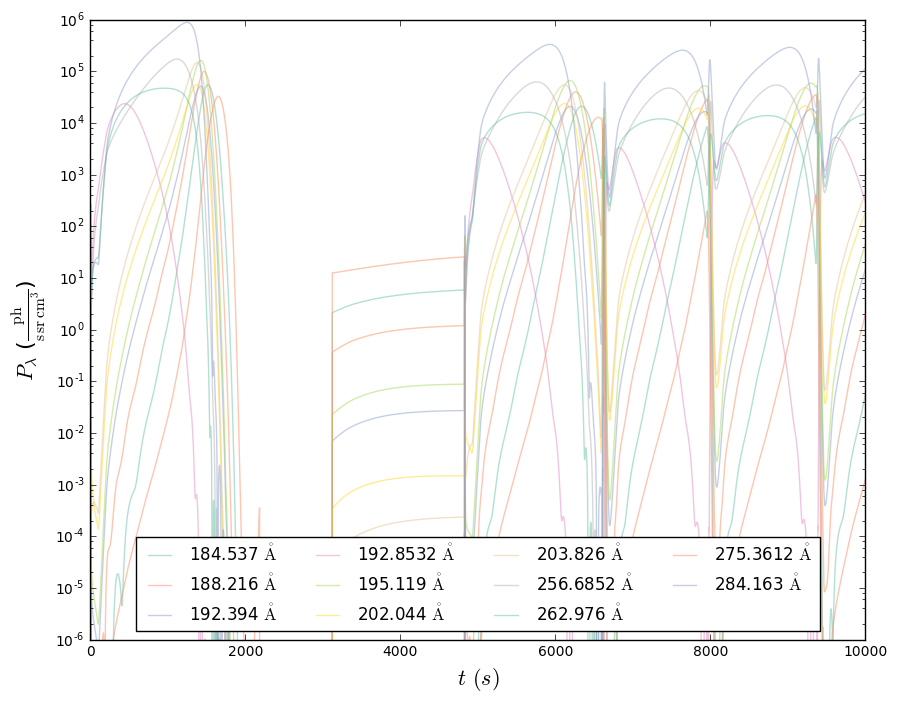

In [99]:
palette = sns.color_palette('Set2',len(emiss_model.wavelengths))
fig = plt.figure(figsize=(10,8))
ax = fig.gca()
loop = field.loops[100]
for i,wvls in enumerate(emiss_model.wavelengths):
    ax.plot(loop.time,
            loop.get_emission(wvls)[:,0],
            label=r'{0} {1:latex}'.format(wvls.value,wvls.unit),color=palette[i],alpha=0.5)
ax.set_yscale('log')
#ax.set_xlim([field.loops[loop_index].time[0].value,field.loops[loop_index].time[-1].value])
#ax.set_xlim([600,900])
ax.set_ylim([1e-6,1e+6])
ax.set_xlabel(r'$t$ $({})$'.format(loop.time.unit),fontsize=16)
ax.set_ylabel(r'$P_{{\lambda}}$ ({0:latex})'.format(loop.get_emission(wvls).unit),fontsize=16)
ax.legend(loc='lower center',ncol=4)

In [57]:
with h5py.File('/data/datadrive2/ar_viz/synthesizar_v01demo/loop_emiss.h5','r') as hf:
    for key in hf['/loop0/']:
        print(hf['/loop0/{}'.format(key)].attrs['ion_name'])

Fe X
Fe XI
Fe XII
Ca XVII
Fe XII
Fe XIII
Fe XIII
S XIII
Fe XVI
Si VII
Fe XV
